In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

import os
import keras
from keras_unet.models import custom_unet

Populating the interactive namespace from numpy and matplotlib


2023-04-01 23:22:55.559201: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
/home/jiehyun.kim001/miniconda3/envs/O/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [2]:
DATAPATH = '/raid/mpsych/CACTAS/DATA/ESUS/'
images_file = os.path.join(DATAPATH, 'images.npy')
labels_file = os.path.join(DATAPATH, 'labels.npy')

In [3]:
images = np.load(images_file)
labels = np.load(labels_file)

In [4]:
# full dataset does not have the last channel
images = images.reshape(images.shape[0],images.shape[1],images.shape[2],1)
labels = labels.reshape(labels.shape[0],labels.shape[1],labels.shape[2],1)

In [5]:
p = np.random.permutation(len(images))

In [6]:
images = images[p]
labels = labels[p]

In [7]:
labels = labels.astype(np.float64)

In [8]:
images = images.astype(np.float64)

for i in range(images.shape[0]):
    images[i] = (images[i] - images[i].min()) / (images[i].max() - images[i].min()) # normalize individually

In [9]:
images.shape, labels.shape

((766, 512, 512, 1), (766, 512, 512, 1))

In [10]:
#import json

In [11]:
#with open("image_data_v3.json", "r") as fp:
#    image_data = json.load(fp)
#with open("label_data_v3.json", "r") as fp:
#    label_data = json.load(fp)

In [12]:
#X_train = images[0:image_data['84']] 
#y_train = labels[0:label_data['84']]
#X_val = images[image_data['84']:]
#y_val = labels[label_data['84']:]

In [10]:
from sklearn.model_selection import train_test_split

In [12]:
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=0)

In [13]:
model = custom_unet(
    input_shape=(512, 512, 1),
    use_batch_norm=False,
    num_classes=1,
    filters=64,
    dropout=0.2,
    dropout_change_per_layer=0.0,
    num_layers=4,
    output_activation='sigmoid')

2023-04-01 23:23:19.342519: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-04-01 23:23:19.577006: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:07:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-04-01 23:23:19.579632: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:b7:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-04-01 23:23:19.579651: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-04-01 23:23:19.583171: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-04-01 

In [14]:
from keras_unet.metrics import iou, iou_thresholded
from keras_unet.losses import jaccard_distance
from tensorflow.keras.optimizers import Adam

In [15]:
model.compile(optimizer = Adam(learning_rate=0.001),
              loss='binary_crossentropy', 
              metrics=[iou, iou_thresholded])

In [16]:
history = model.fit(X_train, 
                    y_train,
                    batch_size=32, 
                    epochs=200,
                    validation_data=(X_val, y_val))

2023-04-01 23:23:27.135790: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-04-01 23:23:27.157183: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2245645000 Hz


Epoch 1/200


2023-04-01 23:23:28.367886: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2023-04-01 23:23:28.997679: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8201
2023-04-01 23:23:29.677770: W tensorflow/stream_executor/gpu/asm_compiler.cc:191] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.0
2023-04-01 23:23:29.677791: W tensorflow/stream_executor/gpu/asm_compiler.cc:194] Used ptxas at ptxas
2023-04-01 23:23:29.677857: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Unimplemented: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-04-01 23:23:29.762001: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-04-01 23:23:30.573198: I tensorflow/stream_exec

20/20 [==============================] - 54s 2s/step - loss: 1.0331 - iou: 5.4220e-05 - iou_thresholded: 3.7181e-04 - val_loss: 0.0475 - val_iou: 3.9794e-06 - val_iou_thresholded: 2.8048e-04
Epoch 2/200
20/20 [==============================] - 19s 969ms/step - loss: 0.0275 - iou: 9.0546e-05 - iou_thresholded: 2.8264e-04 - val_loss: 0.0090 - val_iou: 1.2822e-04 - val_iou_thresholded: 2.8048e-04
Epoch 3/200
20/20 [==============================] - 19s 965ms/step - loss: 0.0078 - iou: 2.4725e-04 - iou_thresholded: 3.5998e-04 - val_loss: 0.0046 - val_iou: 3.4468e-04 - val_iou_thresholded: 2.8048e-04
Epoch 4/200
20/20 [==============================] - 19s 965ms/step - loss: 0.0051 - iou: 4.8979e-04 - iou_thresholded: 2.8941e-04 - val_loss: 0.0046 - val_iou: 7.4609e-04 - val_iou_thresholded: 2.8048e-04
Epoch 5/200
20/20 [==============================] - 19s 972ms/step - loss: 0.0045 - iou: 7.8112e-04 - iou_thresholded: 3.3209e-04 - val_loss: 0.0038 - val_iou: 9.9234e-04 - val_iou_threshold

20/20 [==============================] - 19s 969ms/step - loss: 0.0027 - iou: 0.0136 - iou_thresholded: 3.0761e-04 - val_loss: 0.0023 - val_iou: 0.0191 - val_iou_thresholded: 2.8048e-04
Epoch 43/200
20/20 [==============================] - 19s 963ms/step - loss: 0.0026 - iou: 0.0165 - iou_thresholded: 3.2638e-04 - val_loss: 0.0023 - val_iou: 0.0181 - val_iou_thresholded: 2.8048e-04
Epoch 44/200
20/20 [==============================] - 19s 971ms/step - loss: 0.0025 - iou: 0.0208 - iou_thresholded: 3.6469e-04 - val_loss: 0.0021 - val_iou: 0.0297 - val_iou_thresholded: 2.8048e-04
Epoch 45/200
20/20 [==============================] - 19s 965ms/step - loss: 0.0024 - iou: 0.0233 - iou_thresholded: 3.7600e-04 - val_loss: 0.0021 - val_iou: 0.0298 - val_iou_thresholded: 2.8048e-04
Epoch 46/200
20/20 [==============================] - 19s 971ms/step - loss: 0.0024 - iou: 0.0266 - iou_thresholded: 3.8177e-04 - val_loss: 0.0019 - val_iou: 0.0367 - val_iou_thresholded: 6.1652e-04
Epoch 47/200
20/20

Epoch 84/200
20/20 [==============================] - 19s 963ms/step - loss: 0.0050 - iou: 5.3801e-04 - iou_thresholded: 3.5908e-04 - val_loss: 0.0035 - val_iou: 8.2883e-04 - val_iou_thresholded: 2.8048e-04
Epoch 85/200
20/20 [==============================] - 19s 965ms/step - loss: 0.0039 - iou: 0.0012 - iou_thresholded: 4.6856e-04 - val_loss: 0.0031 - val_iou: 0.0019 - val_iou_thresholded: 2.8048e-04
Epoch 86/200
20/20 [==============================] - 19s 964ms/step - loss: 0.0038 - iou: 0.0018 - iou_thresholded: 4.7938e-04 - val_loss: 0.0031 - val_iou: 0.0016 - val_iou_thresholded: 2.8048e-04
Epoch 87/200
20/20 [==============================] - 19s 967ms/step - loss: 0.0036 - iou: 0.0024 - iou_thresholded: 4.6250e-04 - val_loss: 0.0038 - val_iou: 8.3567e-04 - val_iou_thresholded: 2.8048e-04
Epoch 88/200
20/20 [==============================] - 19s 965ms/step - loss: 0.0036 - iou: 0.0027 - iou_thresholded: 3.8288e-04 - val_loss: 0.0029 - val_iou: 0.0039 - val_iou_thresholded: 2.80

Epoch 125/200
20/20 [==============================] - 19s 966ms/step - loss: 0.0025 - iou: 0.0194 - iou_thresholded: 3.6752e-04 - val_loss: 0.0022 - val_iou: 0.0233 - val_iou_thresholded: 2.8048e-04
Epoch 126/200
20/20 [==============================] - 19s 965ms/step - loss: 0.0025 - iou: 0.0204 - iou_thresholded: 3.3467e-04 - val_loss: 0.0022 - val_iou: 0.0267 - val_iou_thresholded: 2.8048e-04
Epoch 127/200
20/20 [==============================] - 19s 967ms/step - loss: 0.0025 - iou: 0.0221 - iou_thresholded: 3.2489e-04 - val_loss: 0.0026 - val_iou: 0.0238 - val_iou_thresholded: 2.8048e-04
Epoch 128/200
20/20 [==============================] - 19s 962ms/step - loss: 0.0025 - iou: 0.0241 - iou_thresholded: 5.5857e-04 - val_loss: 0.0026 - val_iou: 0.0258 - val_iou_thresholded: 2.8048e-04
Epoch 129/200
20/20 [==============================] - 19s 965ms/step - loss: 0.0025 - iou: 0.0245 - iou_thresholded: 3.4629e-04 - val_loss: 0.0024 - val_iou: 0.0283 - val_iou_thresholded: 2.8048e-04


20/20 [==============================] - 19s 964ms/step - loss: 0.0018 - iou: 0.1088 - iou_thresholded: 0.1389 - val_loss: 0.0016 - val_iou: 0.1364 - val_iou_thresholded: 0.2908
Epoch 168/200
20/20 [==============================] - 19s 967ms/step - loss: 0.0018 - iou: 0.1148 - iou_thresholded: 0.1444 - val_loss: 0.0020 - val_iou: 0.1119 - val_iou_thresholded: 0.3034
Epoch 169/200
20/20 [==============================] - 19s 964ms/step - loss: 0.0018 - iou: 0.1141 - iou_thresholded: 0.1574 - val_loss: 0.0016 - val_iou: 0.1335 - val_iou_thresholded: 0.2762
Epoch 170/200
20/20 [==============================] - 19s 963ms/step - loss: 0.0020 - iou: 0.1102 - iou_thresholded: 0.1501 - val_loss: 0.0017 - val_iou: 0.1156 - val_iou_thresholded: 0.2282
Epoch 171/200
20/20 [==============================] - 19s 967ms/step - loss: 0.0019 - iou: 0.1073 - iou_thresholded: 0.1474 - val_loss: 0.0016 - val_iou: 0.1346 - val_iou_thresholded: 0.2941
Epoch 172/200
20/20 [==============================] -

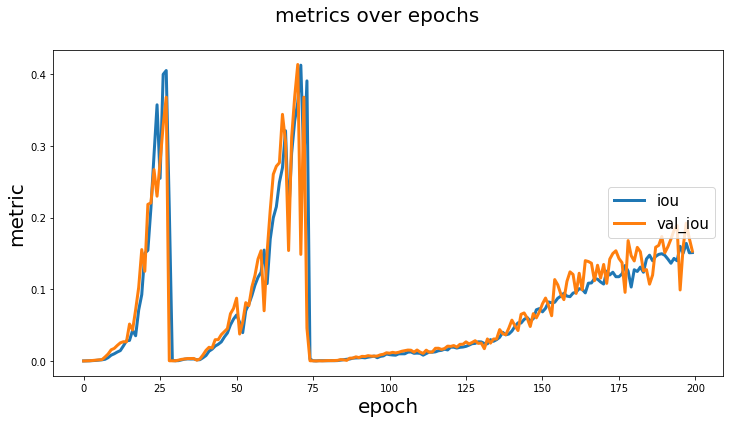

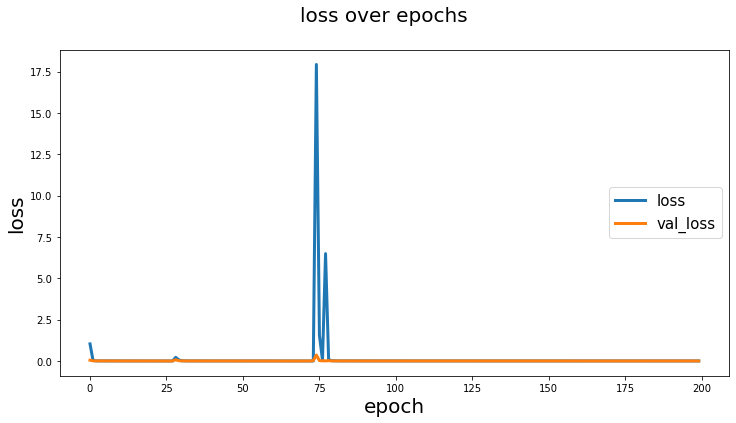

In [17]:
from keras_unet.utils import plot_segm_history

plot_segm_history(history)

In [18]:
y_pred = model.predict(X_val)

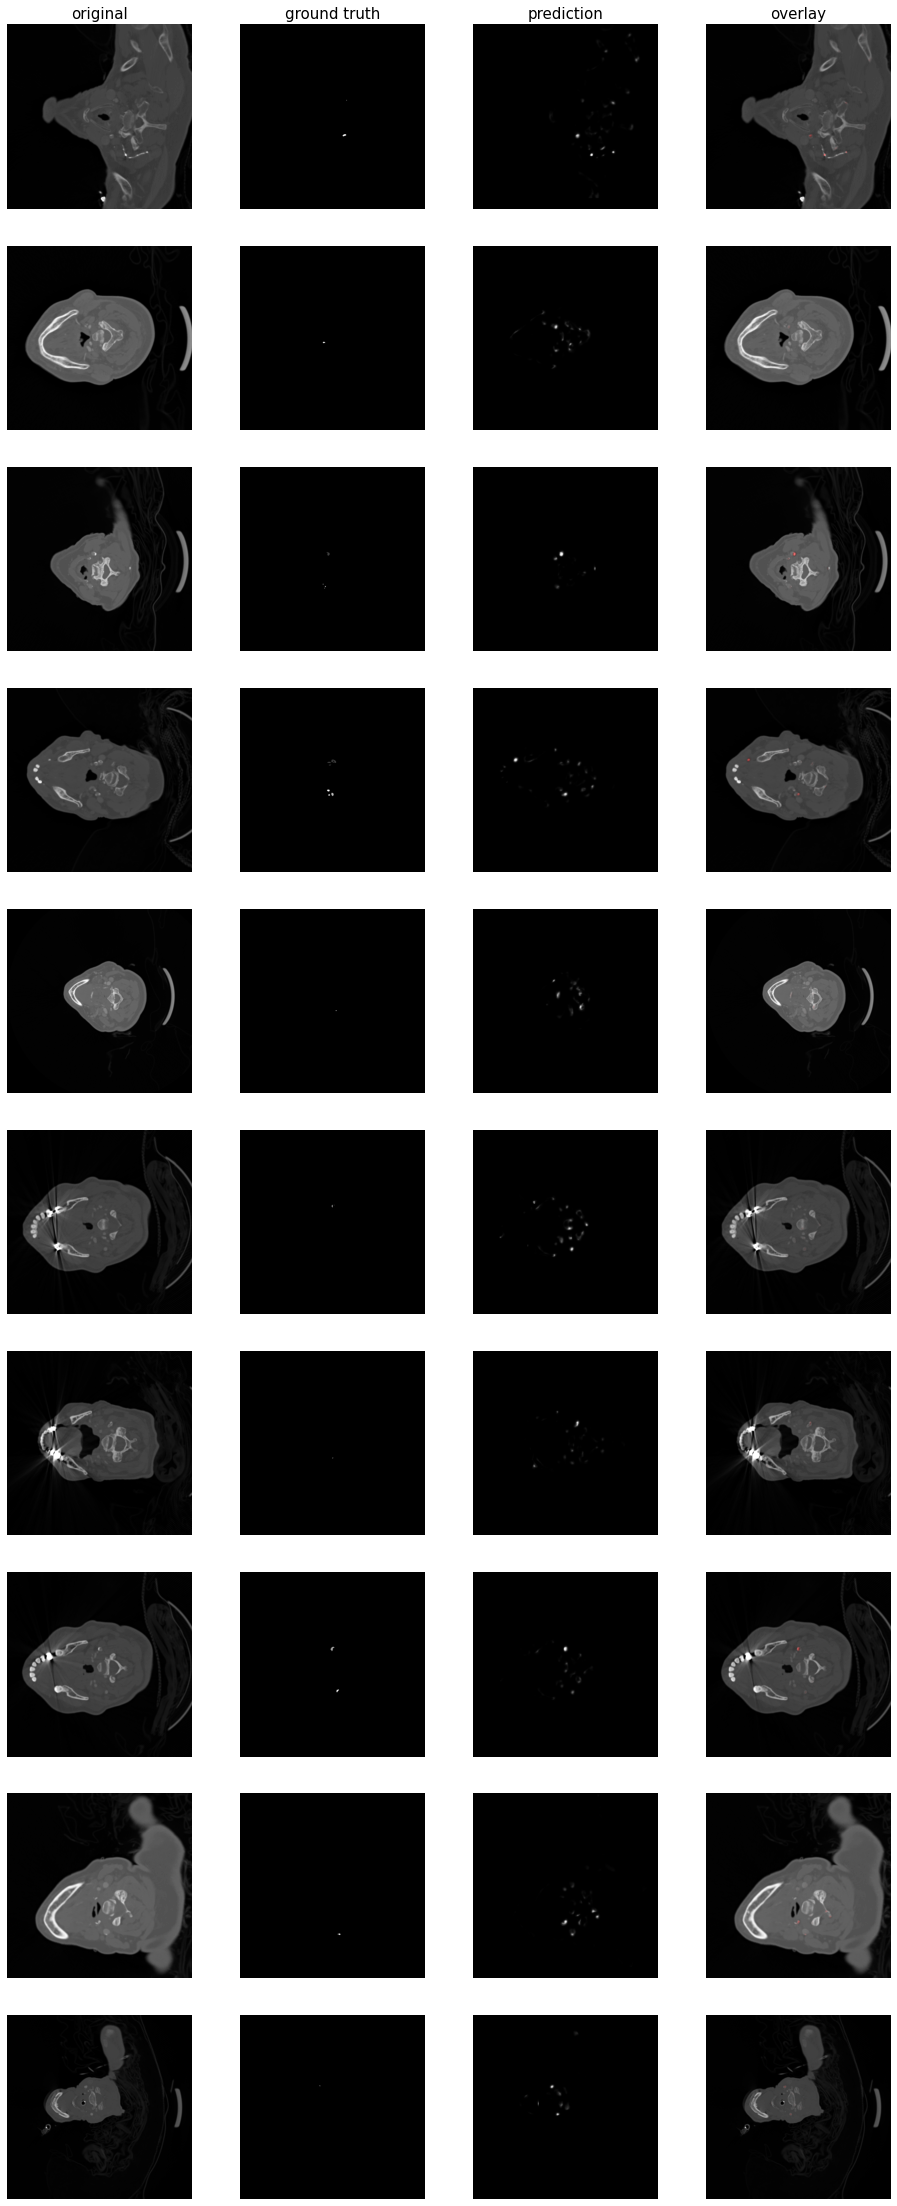

In [19]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=X_val, mask_imgs=y_val, pred_imgs=y_pred, nm_img_to_plot=10)

In [20]:
loss, iou, iou_thresholded = model.evaluate(X_val, y_val)

5/5 [==============================] - 1s 206ms/step - loss: 0.0015 - iou: 0.1532 - iou_thresholded: 0.3676
